<a href="https://colab.research.google.com/github/KalanaKariyawasam/RectCoGen/blob/rectcogen_ml_model/RectCoGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Kalana Kariyawasam  
w1809765  
2019353

#RectCoGen: Machine Learning Based Code Generation for Front-end Implementation

**Domain:** Front-end Development  
**Problem Overview:** The labor-intensive and error-prone process of manually converting web wireframes and graphical user interfaces (GUIs) into functional code. Traditionally, this task requires extensive collaboration between designers and developers, leading to increased development time, higher costs, and potential for discrepancies between the intended design and the implemented functionality. RectCoGen seeks to simplify this process by introducing an automated solution that transforms design blueprints into React components, aiming to improve efficiency, reduce errors, and lower financial burdens associated with web development.








#Initial Setup


In [11]:
from os import listdir
from numpy import array
import numpy as np
import os
from sklearn.model_selection import train_test_split

# Importing necessary functions from tensorflow.keras instead of keras
from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential, model_from_json
from tensorflow.keras.utils import to_categorical
# Updated import path for Dense, Dropout, Flatten
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, Embedding, TimeDistributed, RepeatVector, LSTM, concatenate, Input, Reshape
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
# Directory where the data is stored
data_dir = '/content/drive/MyDrive/Datasets/web/all_data'

# Lists to store paths of images and their labels
image_paths = []
labels = []

# Assuming images and their corresponding markup files are in the same directory
for filename in os.listdir(data_dir):
    if filename.endswith('.png'):  # or '.jpg' depending on your dataset
        image_paths.append(os.path.join(data_dir, filename))
        label_path = os.path.join(data_dir, filename.replace('.png', '.gui'))  # Adjust the extension based on your data
        labels.append(label_path)

# Split the data into training and evaluation sets
X_train, X_eval, y_train, y_eval = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# X_train and y_train are your training images and labels respectively
# X_eval and y_eval are your evaluation images and labels respectively

#Training Parameters

In [5]:
# Check if GPU is available and set hyperparameters accordingly
if tf.config.list_physical_devices('GPU'):
    # GPU settings
    EPOCHS = 50
    MAX_SEQUENCE = 150
    MAX_LEN = 48
else:
    # CPU settings
    EPOCHS = 50
    MAX_SEQUENCE = 100
    MAX_LEN = 48
    print("WARNING: Switch on GPU for faster training!")


#Data Preperartion

In [18]:
# Function to display an image
def show_img(im, figsize=None, ax=None):
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.axis('off')  # Hide axes ticks
    return ax

# Function to load a document's text
def load_doc(filename):
    with open(filename, 'r') as file:
        text = file.read()
    return text

# Function to load data (images and text) from a directory
def load_data(data_dir):
    texts = []
    images = []
    # Load all the files and order them
    all_filenames = sorted(os.listdir(data_dir))  # Sort to maintain alignment
    for filename in all_filenames:
        if filename.endswith(".npz"):
            # Load image data prepared in npz array format
            image = np.load(os.path.join(data_dir, filename))
            images.append(image['features'])
        elif filename.endswith(".gui"):
            # Load and format the text
            syntax = '<START> ' + load_doc(os.path.join(data_dir, filename)) + ' <END>'
            syntax = ' '.join(syntax.split())  # Ensure single spaces
            syntax = syntax.replace(',', ' ,')  # Space after commas
            texts.append(syntax)
    images = np.array(images, dtype=float)  # Ensure all images are float arrays
    return images, texts

# Adjusted to use your training path
DS_PATH = '/content/drive/MyDrive/Datasets/web/all_data/'  # Ensure this is your correct path
train_features, texts = load_data(DS_PATH)


#Visualization

Here's what an example looks like

GUI text: <START> header { btn-active , btn-inactive , btn-inactive , btn-inactive } row { single { small-title , text , btn-orange } } row { double { small-title , text , btn-orange } double { small-title , text , btn-orange } } row { double { small-title , text , btn-red } double { small-title , text , btn-orange } } <END>


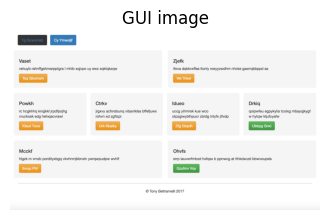

In [12]:
# Function to display an image
def show_img(img_path, figsize=(4,4)):
    im = Image.open(img_path)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_title('GUI image')
    ax.axis('off')  # Hide axes ticks
    return ax

# Assuming texts is a list of GUI markup strings and image_paths is a list of image file paths
print("Here's what an example looks like\n")
print("GUI text:", texts[0])

# Since train_features should now directly contain the paths to your images
# Use the first image path in your list for visualization
ax = show_img(image_paths[0], figsize=(4,4))



In [20]:
# Dataset info as Sanity check
train_features.shape, len(texts)

((0,), 1747)